# Dog Breeds Image Classification

In this notebook, we will use [dog breed images](http://vision.stanford.edu/aditya86/ImageNetDogs/) and use transfer learning to identify the dog breed. The hyperparameter tuning and model training are done using Sagemaker training job.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
INSTALL_PACKAGES = False
if INSTALL_PACKAGES:
    !pip install smdebug
    !pip install tqdm

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import numpy as np

BUCKET = 'project03-image-classification-vexenta'

## Dataset

*TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.*

The dataset contains images of 133 dog breeds, which are already split into train, validation, and test sets.

In [3]:
# TODO: Fetch and upload the data to AWS S3
DOWNLOAD_DATASET = False
if DOWNLOAD_DATASET:
    # Command to download and unzip data
    !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
    !unzip dogImages.zip
    
UPLOAD_TO_S3 = False
os.environ["DEFAULT_S3_BUCKET"] = BUCKET

if UPLOAD_TO_S3:
    !aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/data/train/
    !aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/data/valid/
    !aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/data/test/

There are 133 dog breeds; each dog breed image is stored in a directory. There are at least 20 images per breed.

In [4]:
## ensure the files are successfully uploaded
CHECK_UPLOAD = True
if CHECK_UPLOAD:
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/train/  | wc -l
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/valid/ | wc -l
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/test/ | wc -l
        
    ## preview of the breeds
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/train/ | tail -n 10

133
133
133
                           PRE 124.Poodle/
                           PRE 125.Portuguese_water_dog/
                           PRE 126.Saint_bernard/
                           PRE 127.Silky_terrier/
                           PRE 128.Smooth_fox_terrier/
                           PRE 129.Tibetan_mastiff/
                           PRE 130.Welsh_springer_spaniel/
                           PRE 131.Wirehaired_pointing_griffon/
                           PRE 132.Xoloitzcuintli/
                           PRE 133.Yorkshire_terrier/


### Dataset Preview

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def show_image(image_file_directory: str = None, image_file_path: str = None):
    if image_file_path is None:
        assert image_file_directory is not None, "image_file_directory must be specified if image_file_path is None!"
        image_file_name_list = os.listdir(image_file_directory)
        selected_image_index = np.random.choice(len(image_file_name_list))
        selected_image_file_name = image_file_name_list[selected_image_index]
        image_file_path = os.path.join(
            image_file_directory,
            selected_image_file_name
        )
    else:
        selected_image_file_name = image_file_path.split("/")[-1]
    
    img = mpimg.imread(image_file_path)
    img_plot = plt.imshow(img)
    plt.title(selected_image_file_name)
    plt.show()

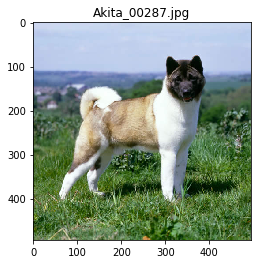

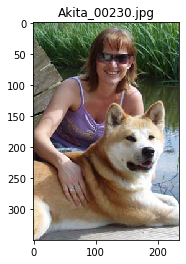

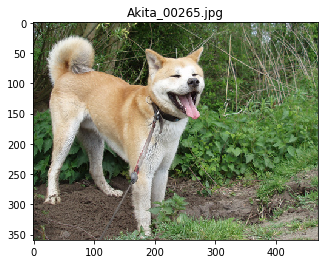

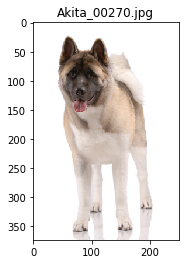

In [6]:
show_image(image_file_directory="dogImages/train/004.Akita")
show_image(image_file_path="dogImages/train/004.Akita/Akita_00230.jpg")

show_image(image_file_directory="dogImages/valid/004.Akita")
show_image(image_file_directory="dogImages/test/004.Akita")

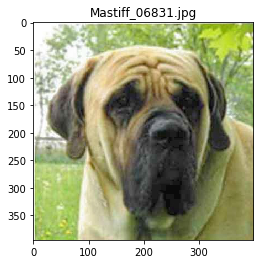

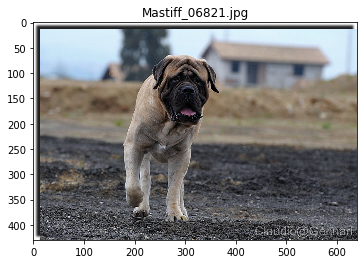

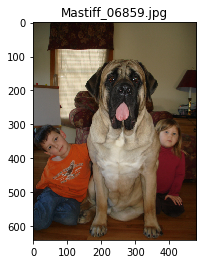

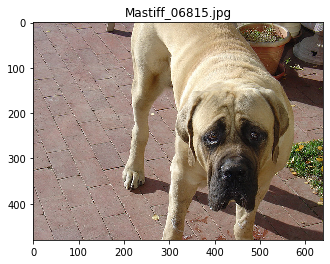

In [7]:
show_image(image_file_directory="dogImages/train/103.Mastiff")
show_image(image_file_path="dogImages/train/103.Mastiff/Mastiff_06821.jpg")

show_image(image_file_directory="dogImages/valid/103.Mastiff")
show_image(image_file_directory="dogImages/test/103.Mastiff")

In [8]:
import pandas as pd
from tqdm import tqdm

def extract_dataset_metadata(dataset_directory: str) -> pd.DataFrame:
    """
    Extract target class, file name, and full file path of the provided dataset directory

    :param dataset_directory: directory where the data are stored
    :type dataset_directory: str
    :return: dataframe that contains metadata: target class, file name, and full file path
    :rtype: pd.DataFrame
    """
    meta = list()
    for directory_name, _, file_names in tqdm(os.walk(dataset_directory)):
        for file_name in file_names:
            class_name = directory_name.split('/')[-1]
            full_path = os.path.join(directory_name, file_name)
            meta.append([
                class_name,
                file_name,
                full_path
            ])
    
    return pd.DataFrame(
        meta, 
        columns=['target_class', 'file_name', 'full_path']
    )

In [9]:
df_meta_train = extract_dataset_metadata(dataset_directory="dogImages/train/")
df_meta_valid = extract_dataset_metadata(dataset_directory="dogImages/valid/")
df_meta_test = extract_dataset_metadata(dataset_directory="dogImages/test/")

134it [00:00, 365.06it/s]
134it [00:00, 417.79it/s]
134it [00:00, 340.63it/s]


In [10]:
## TO DO:
## plot distribution of target class counts in train, validation, test set

In [11]:
df_meta_train["target_class"].value_counts()

005.Alaskan_malamute      77
029.Border_collie         74
015.Basset_hound          73
057.Dalmatian             71
014.Basenji               69
                          ..
126.Saint_bernard         30
102.Manchester_terrier    29
121.Plott                 28
108.Norwegian_buhund      26
132.Xoloitzcuintli        26
Name: target_class, Length: 133, dtype: int64

In [12]:
df_meta_valid["target_class"].value_counts()

005.Alaskan_malamute    9
029.Border_collie       9
039.Bull_terrier        9
015.Basset_hound        9
057.Dalmatian           9
                       ..
108.Norwegian_buhund    4
132.Xoloitzcuintli      4
126.Saint_bernard       4
067.Finnish_spitz       4
066.Field_spaniel       4
Name: target_class, Length: 133, dtype: int64

In [13]:
df_meta_test["target_class"].value_counts()

029.Border_collie                  10
005.Alaskan_malamute               10
015.Basset_hound                   10
012.Australian_shepherd             9
039.Bull_terrier                    9
                                   ..
126.Saint_bernard                   3
121.Plott                           3
108.Norwegian_buhund                3
131.Wirehaired_pointing_griffon     3
132.Xoloitzcuintli                  3
Name: target_class, Length: 133, dtype: int64

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a **minimum of two hyperparameters**. However you are encouraged to tune more. You are also encouraged to explain **why** you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [14]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

role = sagemaker.get_execution_role()

In [15]:
model_output_dir = 's3://project03-image-classification-vexenta/model/hp-tuning/model.tar.gz'
input_train = f"s3://{BUCKET}/data/train/"
input_valid = f"s3://{BUCKET}/data/valid/"
input_test = f"s3://{BUCKET}/data/test/"

os.environ["SM_MODEL_DIR"] = model_output_dir
os.environ["SM_CHANNEL_TRAIN"] = input_train
os.environ["SM_CHANNEL_VALIDATION"] = input_valid
os.environ["SM_CHANNEL_TEST"] = input_test

In [16]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([128, 256]),
    "epochs": CategoricalParameter([5, 7, 10])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}] ## if using cross-entropy loss
# metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: -([0-9\\.]+)"}] ## if using NLLLoss

In [17]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="src/hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c4.4xlarge",
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=2, 
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [18]:
# TODO: Fit your HP Tuner
tuner.fit(
    inputs={
        "train": input_train, 
        "validation": input_valid,
    },
    wait=True
) # TODO: Remember to include your data channels

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [19]:
tuner.best_training_job()

'pytorch-training-211204-2308-001-5c023cd1'

In [20]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-05 00:26:35 Starting - Preparing the instances for training
2021-12-05 00:26:35 Downloading - Downloading input data
2021-12-05 00:26:35 Training - Training image download completed. Training in progress.
2021-12-05 00:26:35 Uploading - Uploading generated training model
2021-12-05 00:26:35 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"7"',
 'lr': '0.0053945745752048664',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-04-23-08-46-531"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-04-23-08-46-531/source/sourcedir.tar.gz"'}

In [23]:
hyperparameters = best_estimator.hyperparameters()

hyperparameters

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"7"',
 'lr': '0.0053945745752048664',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-04-23-08-46-531"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-04-23-08-46-531/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [25]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [37]:
# ## from this training job: pytorch-training-2021-12-04-23-08-46-531
# hyperparameters = {
#     "lr": 0.0053945745752048664,
#     "batch-size": 256,
#     "epochs": 7,
# }

## reformat input
for key in ["epochs","batch-size"]:
    hyperparameters[key] = int(hyperparameters[key].replace('"',''))

In [38]:
hyperparameters

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': 256,
 'epochs': 7,
 'lr': '0.0053945745752048664',
 'sagemaker_container_log_level': 20,
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': 'pytorch-training-2021-12-05-00-47-28-900',
 'sagemaker_program': 'train_model.py',
 'sagemaker_region': 'us-east-1',
 'sagemaker_submit_directory': 's3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-05-00-47-28-900/source/sourcedir.tar.gz'}

In [75]:
# TODO: Create and fit an estimator
TRAIN_MODEL = False

if TRAIN_MODEL:
    estimator = PyTorch(
        entry_point="src/train_model.py",
        role=role,
        py_version='py36',
        framework_version="1.8",
        instance_count=1,
        instance_type="ml.c4.4xlarge", #"ml.m5.2xlarge", #"ml.m5.large",
        hyperparameters=hyperparameters,
        rules=rules,
        debugger_hook_config=hook_config,
        profiler_config=profiler_config,
    ) # TODO: Your estimator here

    estimator.fit(
        inputs={
            "train": input_train, 
    #         "validation": input_valid,
            "test": input_test,
        },
        wait=True
    )
else:
    ## if not re-training the model, just refer to the latest result
    training_job_name = "pytorch-training-2021-12-05-00-56-02-512"
    algo_image = sagemaker.image_uris.retrieve(
        framework='pytorch',
        version="1.8",
        region=session.boto_region_name,
        py_version="py36",
        instance_type="ml.c4.4xlarge",
        image_scope="inference",
    )
    estimator = sagemaker.model.Model(
        image_uri=algo_image,
        model_data="s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-05-00-56-02-512/output/model.tar.gz",
        role=role
    )

2021-12-05 03:17:20 Starting - Starting the training job...
2021-12-05 03:17:45 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-05 03:18:45 Starting - Preparing the instances for training.........
2021-12-05 03:20:13 Downloading - Downloading input data............
2021-12-05 03:22:14 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-05 03:22:13,534 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-05 03:22:13,536 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-05 03:22:13,545 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-05 03:22:13,5

In [76]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2021-12-05 04:36:08.035 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:457 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-05-03-17-20-107/debug-output
[2021-12-05 04:36:08.520 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:457 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-05 04:36:09.542 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:457 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0']

In [91]:
estimator.debugger_hook_config.hook_parameters

{'train.save_interval': '100', 'eval.save_interval': '10'}

In [86]:
trial.tensor_names()

['CrossEntropyLoss_output_0']

In [98]:
trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)

[0]

In [99]:
trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)

[0]

In [95]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

1

In [77]:
def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [78]:
steps_train, vals_train = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.TRAIN)
vals_train

[array(5.055378, dtype=float32)]

In [79]:
steps_eval, vals_eval = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.EVAL)
vals_eval

[array(1.0400798, dtype=float32)]

In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


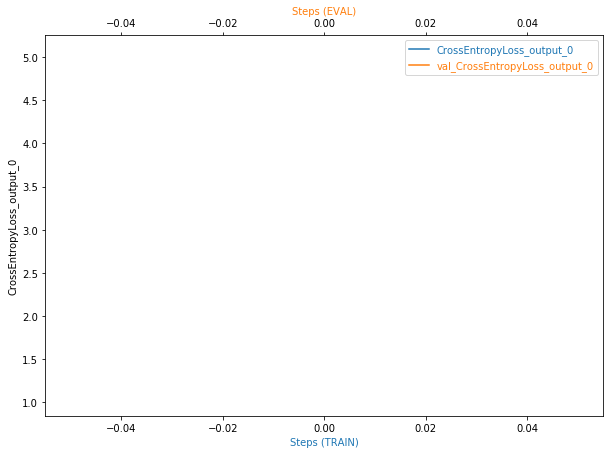

In [81]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [82]:
# TODO: Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")
!aws s3 ls {rule_output_path} --recursive

## copy to local
!aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-05-03-17-20-107/rule-output
2021-12-05 04:34:35     375321 pytorch-training-2021-12-05-03-17-20-107/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-05 04:34:34     223223 pytorch-training-2021-12-05-03-17-20-107/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-05 04:34:30        192 pytorch-training-2021-12-05-03-17-20-107/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-05 04:34:30        200 pytorch-training-2021-12-05-03-17-20-107/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-05 04:34:30       2202 pytorch-training-2021-12-05-03-17-20-107/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-05 04:34:30        127 pytorch-training-2021-12-05-03-17-20-107/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

In [83]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [84]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [72]:
# TODO: Deploy your model to an endpoint
# TODO: Add your deployment configuration like instance type and number of instances
deployment = estimator.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.xlarge"
)
endpoint = deployment.endpoint_name

predictor = sagemaker.predictor.Predictor(
    endpoint,
    sagemaker_session=sagemaker.Session(),
)

In [ ]:
# import sagemaker 

# session = sagemaker.Session()
# role = sagemaker.get_execution_role()

# training_job_name = "pytorch-training-2021-12-05-02-50-55-622" #"pytorch-training-2021-12-04-10-33-23-149"
# algo_image = sagemaker.image_uris.retrieve(
#     framework='pytorch',
#     version="1.8",
#     region=session.boto_region_name,
#     py_version="py36",
#     instance_type="ml.t2.medium",
#     image_scope="inference",
# )
# model = sagemaker.model.Model(
#     image_uri=algo_image,
#     model_data=f"s3://sagemaker-us-east-1-214854311692/{training_job_name}/output/model.tar.gz",
#     role=role
# )

# predictor = model.deploy(
#     initial_instance_count=1, 
#     instance_type="ml.m5.xlarge"
# )

In [ ]:
# TODO: Run an prediction on the endpoint

from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("dogImages/train/004.Akita/Akita_00230.jpg", "rb") as f:
    payload = f.read()
    
image = payload # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [ ]:
# import gzip 
# import numpy as np
# import random
# import os

# data_dir = 'data/MNIST/raw'
# with gzip.open(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "rb") as f:
#     images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

# mask = random.sample(range(len(images)), 16) # randomly select some of the test images
# mask = np.array(mask, dtype=np.int)
# data = images[mask]

# response = predictor.predict(np.expand_dims(data, axis=1))
# print("Raw prediction result:")
# print(response)
# print()

# labeled_predictions = list(zip(range(10), response[0]))
# print("Labeled predictions: ")
# print(labeled_predictions)
# print()

# labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
# print("Most likely answer: {}".format(labeled_predictions[0]))